In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

sess=tf.Session()

In [2]:
#加载数据，并转换为28*28的图像
data_dir='temp'
mnist=read_data_sets(data_dir)
train_xdata=np.array([np.reshape(x,(28,28)) for x in mnist.train.images])
test_xdata=np.array([np.reshape(x,(28,28)) for x in mnist.test.images])
train_labels=mnist.train.labels
test_labels=mnist.test.labels

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting temp\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting temp\train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting temp\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting temp\t10k-labels-idx1-ubyte.gz


In [3]:
#设置模型参数
batch_size=100
learning_rate=0.005
evaluation_size=500
image_width=train_xdata[0].shape[0]
image_hight=train_xdata[0].shape[1]
target_size=max(train_labels)+1
num_channels=1
generations=500
eval_every=5
conv1_features=25
conv2_features=50
max_pool_size1=2
max_pool_size2=2
fully_connected_size1=100

In [4]:
#为数据集声明占位符，同时声明训练数据集变量和测试数据集变量，
x_input_shape=(batch_size,image_width,image_hight,num_channels)
x_input=tf.placeholder(tf.float32,shape=x_input_shape)
y_target=tf.placeholder(tf.int32,shape=(batch_size))
eval_input_shape=(evaluation_size,image_width,image_hight,num_channels)
eval_input=tf.placeholder(tf.float32,shape=eval_input_shape)
eval_target=tf.placeholder(tf.int32,shape=(evaluation_size))

In [5]:
#声明卷积层的权重和偏置
conv1_weight=tf.Variable(tf.truncated_normal([4,4,num_channels,conv1_features],stddev=0.1,dtype=tf.float32))
conv1_bias=tf.Variable(tf.zeros([conv1_features],dtype=tf.float32))
conv2_weight=tf.Variable(tf.truncated_normal([4,4,conv1_features,conv2_features],stddev=0.1,dtype=tf.float32))
conv2_bias=tf.Variable(tf.zeros([conv2_features],dtype=tf.float32))

In [6]:
#声明全连接层的权重和偏置
resulting_width=image_width//(max_pool_size1*max_pool_size2)
resulting_height=image_hight//(max_pool_size1*max_pool_size2)
full1_input_size=resulting_width*resulting_height*conv2_features
full1_weight=tf.Variable(tf.truncated_normal([full1_input_size,fully_connected_size1],stddev=0.1,dtype=tf.float32))
full1_bias=tf.Variable(tf.truncated_normal([fully_connected_size1],stddev=0.1,dtype=tf.float32))
full2_weight=tf.Variable(tf.truncated_normal([fully_connected_size1,target_size],stddev=0.1,dtype=tf.float32))
full2_bias=tf.Variable(tf.truncated_normal([target_size],stddev=0.1,dtype=tf.float32))

In [7]:
#声明算法模型
def my_conv_net(input_data):
    # first conv-ReLU-MaxPool Layer
    conv1=tf.nn.conv2d(input_data,conv1_weight,strides=[1,1,1,1],padding='SAME')
    relu1=tf.nn.relu(tf.nn.bias_add(conv1,conv1_bias))
    max_pool1=tf.nn.max_pool(relu1,ksize=[1,max_pool_size1,max_pool_size1,1],strides=[1,max_pool_size1,max_pool_size1,1],padding='SAME')
    
    #second conv-relu-maxpool layer
    conv2=tf.nn.conv2d(max_pool1,conv2_weight,strides=[1,1,1,1],padding='SAME')
    relu2=tf.nn.relu(tf.nn.bias_add(conv2,conv2_bias))
    max_pool2=tf.nn.max_pool(relu2,ksize=[1,max_pool_size2,max_pool_size2,1],strides=[1,max_pool_size2,max_pool_size2,1],padding='SAME')
    
    #transform output into a 1xN layer for next fully connected layer
    final_conv_shape=max_pool2.get_shape().as_list()
    final_shape=final_conv_shape[1]*final_conv_shape[2]*final_conv_shape[3]
    flat_output=tf.reshape(max_pool2,[final_conv_shape[0],final_shape])
    #first fully connected layer
    fully_connected1=tf.nn.relu(tf.add(tf.matmul(flat_output,full1_weight),full1_bias))
    # second fully connected layer
    final_model_output=tf.add(tf.matmul(fully_connected1,full2_weight),full2_bias)
    return (final_model_output)

In [8]:
# 声明训练模型
model_output=my_conv_net(x_input)
test_model_output=my_conv_net(eval_input)
#采用softmax函数作为损失函数
loss=tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))

#创建训练集和测试集的预测函数
prediction=tf.nn.softmax(model_output)
test_prediction=tf.nn.softmax(test_model_output)

#计算精度
def get_accuracy(logits,target):
    batch_predictions=np.argmax(logits,axis=1)
    num_correct=np.sum(np.equal(batch_predictions,target))
    return (100.*num_correct/batch_predictions.shape[0])

In [9]:
#创建优化器函数，声明训练步长，初始化所有的模型变量
my_optimizer=tf.train.MomentumOptimizer(learning_rate,0.9)
train_step=my_optimizer.minimize(loss)
#initialize varialbles
init=tf.global_variables_initializer()
sess.run(init)

In [10]:
#开始训练模型
train_loss=[]
train_acc=[]
test_acc=[]
for i in range(generations):
    rand_index=np.random.choice(len(train_xdata),size=batch_size)
    rand_x=train_xdata[rand_index]
    rand_x=np.expand_dims(rand_x,3)
    rand_y=train_labels[rand_index]
    train_dict={x_input:rand_x,y_target:rand_y}
    sess.run(train_step,feed_dict=train_dict)
    temp_train_loss,temp_train_preds=sess.run([loss,prediction],feed_dict=train_dict)
    temp_train_acc=get_accuracy(temp_train_preds,rand_y)
    if(i+1)%eval_every==0:
        eval_index=np.random.choice(len(test_xdata),size=evaluation_size)
        eval_x=test_xdata[eval_index]
        eval_x=np.expand_dims(eval_x,3)
        eval_y=test_labels[eval_index]
        test_dict={eval_input:eval_x,eval_target:eval_y}
        test_preds=sess.run(test_prediction,feed_dict=test_dict)
        temp_test_acc=get_accuracy(test_preds,eval_y)
        
        #record and print result
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
        acc_and_loss=[(i+1),temp_train_loss,temp_train_acc,temp_test_acc]
        acc_and_loss=[np.round(x,2) for x in acc_and_loss]
        print('迭代#{}. Train loss:{:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

迭代#5. Train loss:2.33. Train Acc (Test Acc): 13.00 (11.80)
迭代#10. Train loss:2.19. Train Acc (Test Acc): 28.00 (17.40)
迭代#15. Train loss:2.14. Train Acc (Test Acc): 29.00 (27.00)
迭代#20. Train loss:2.05. Train Acc (Test Acc): 44.00 (44.00)
迭代#25. Train loss:1.92. Train Acc (Test Acc): 51.00 (56.40)
迭代#30. Train loss:1.68. Train Acc (Test Acc): 72.00 (64.00)
迭代#35. Train loss:1.39. Train Acc (Test Acc): 74.00 (68.20)
迭代#40. Train loss:1.07. Train Acc (Test Acc): 77.00 (77.80)
迭代#45. Train loss:0.94. Train Acc (Test Acc): 70.00 (76.00)
迭代#50. Train loss:0.67. Train Acc (Test Acc): 81.00 (82.80)
迭代#55. Train loss:0.58. Train Acc (Test Acc): 84.00 (81.60)
迭代#60. Train loss:0.60. Train Acc (Test Acc): 80.00 (84.20)
迭代#65. Train loss:0.61. Train Acc (Test Acc): 84.00 (85.00)
迭代#70. Train loss:0.48. Train Acc (Test Acc): 86.00 (86.60)
迭代#75. Train loss:0.30. Train Acc (Test Acc): 92.00 (83.80)
迭代#80. Train loss:0.49. Train Acc (Test Acc): 87.00 (89.40)
迭代#85. Train loss:0.48. Train Acc (Test A

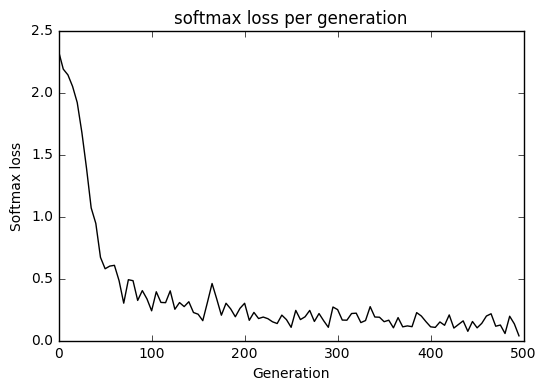

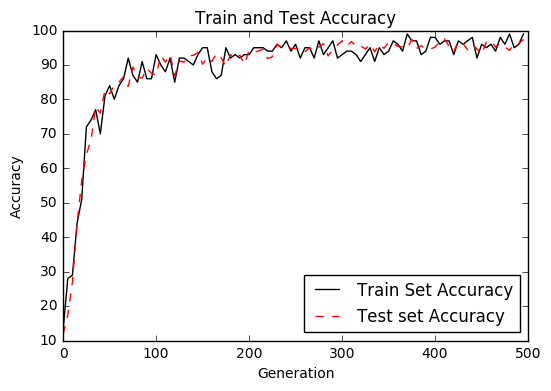

In [11]:
#使用matplotlib模块绘制损失函数和准确度的代码
eval_indices=range(0,generations,eval_every)
#plot loss over time
plt.plot(eval_indices,train_loss,'k-')
plt.title('softmax loss per generation')
plt.xlabel('Generation')
plt.ylabel('Softmax loss')
plt.show()

#plot train and test accuracy
plt.plot(eval_indices,train_acc,'k-',label='Train Set Accuracy')
plt.plot(eval_indices,test_acc,'r--',label='Test set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()